# АНАЛИЗ ПОВЕДЕНИЯ ПОЛЬЗОВАТЕЛЕЙ МОБИЛЬНОГО ПРИЛОЖЕНИЯ

**ЦЕЛЬ:**   
Необходимо разобраться, как ведут себя пользователи мобильного приложения по продаже продуктов питания.   

**План:**
- изучить и обработать данные;
- изучить воронку продаж;
- узнайть, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно;
- исследовать результаты A/A/B-эксперимента по смене шрифта в приложениии. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выяснить, какой шрифт лучше.

*Описание данных*   

Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Предобработка данных

Импортируем необходимые библиотеки и загрузим данные, подобрав разделитель.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
import plotly.express as px
from plotly import graph_objects as go

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

Выведем первые строки датасета для ознакомления

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Создадим функцию для вывода общей информации по датафрейму: размер, типы данных и количество пропусков в солбцах, наименования столбцов отдельно

In [4]:
def describe(df: pd.DataFrame):
    display(f'Общая информация: {df.shape}')
    display(df.info())
    print('Дубликаты в массиве:', df.duplicated().sum(), 'в процентах:', round(df.duplicated().mean()*100, 2))
    display(f'Названия столбцов: {df.columns}')

In [5]:
describe(df)

'Общая информация: (244126, 4)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Дубликаты в массиве: 413 в процентах: 0.17


"Названия столбцов: Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')"

Количество строк-дубликатов по отношению к общему объему данных невелико (0,17%), поэтому их можно удалить.

In [6]:
df = df.drop_duplicates().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       243713 non-null  object
 1   DeviceIDHash    243713 non-null  int64 
 2   EventTimestamp  243713 non-null  int64 
 3   ExpId           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Переименуем столбцы массива:

In [7]:
df = df.rename(columns={'EventName': 'event', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'timestamp', 'ExpId': 'group'})
df.head()

,event,user_id,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Приведем данные в столбце с датами к соответствующему формату, учитывая что время дано в формате UTC.

In [8]:
df['timedate'] = pd.to_datetime(df['timestamp'], unit='s')
df.head()

,event,user_id,timestamp,group,timedate
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


Добавим столбец только с датой в нужном формате:

In [9]:
df['date'] = df['timedate'].dt.date
df.head()

,event,user_id,timestamp,group,timedate,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [10]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   user_id    243713 non-null  int64         
 2   timestamp  243713 non-null  int64         
 3   group      243713 non-null  int64         
 4   timedate   243713 non-null  datetime64[ns]
 5   date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


**Вывод:**  после загрузки библиотек и данных, первичного ознакомления с данными - была проведена обработка.   

В процессе предобработки:
- заменены названия столбцов со сменой регистра;
- проверены пропуски и типы данных. Откорректированы;
- удалены полные дубликаты строк;
- добавлен столбец даты и времени, а также отдельный столбец дат.

## Изучение и проверка данных

После обработки данных в нашем массиве 43713 строк с событиями. Выведем типы этих событий и их количество.

In [11]:
events=len(df['event'])
events

243713

In [12]:
df['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

Узнаем количество пользователей с уникальными идентификаторами.

In [13]:
users1 = len(df['user_id'].unique())
users1

7551

Подсчитаем количество событий на пользователя в среднем

In [14]:
visits = df.groupby('user_id')['event'].count()
visits.mean().round()

32.0

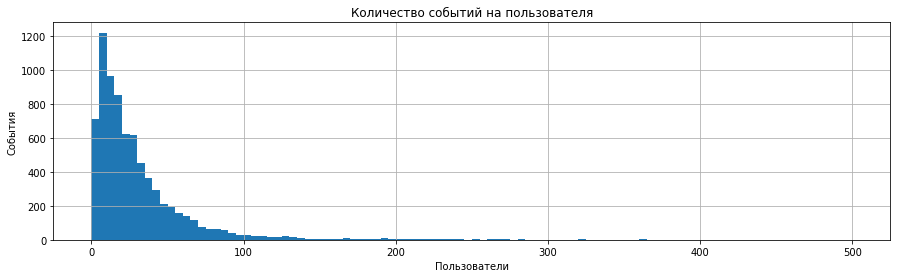

In [15]:
plt.figure(figsize=(15,4))
plt.hist(visits, bins=100, range=(0,500)) 
plt.xlabel('Пользователи')
plt.grid()
plt.ylabel('События')
plt.title('Количество событий на пользователя')
plt.show()

In [16]:
visits.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

Распределение скошено влево. Большая разница в максимуме и минимуме. Есть смысл рассмотреть все стат. характеристики и учитывать медиану, равную 20, а не среднее.

Определим, данными за какой период мы располагаем:

In [17]:
max = df['date'].dt.date.max()
display('Максимальная дата привлечения пользователей {}'.format(max))

'Максимальная дата привлечения пользователей 2019-08-07'

In [18]:
min = df['date'].dt.date.min()
display('Минимальная дата привлечения пользователей {}'.format(min))

'Минимальная дата привлечения пользователей 2019-07-25'

Имеются данные с 25 июля по 7 августа 2019 года, за 2 недели. Построим гистограмму, чтобы увидеть распределение данных во времени.

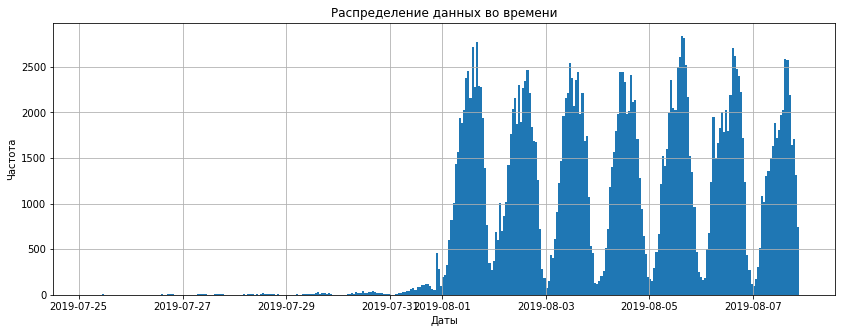

In [19]:
df['timedate'].hist(bins=14*24, figsize=(14, 5))
plt.xlabel('Даты')
plt.ylabel('Частота')
plt.title('Распределение данных во времени')
plt.show()

Основное количество данных приходится на вторую неделю, начиная с 01.08.2019. Отбросим данные за июль.

In [20]:
data = df.query('date > "2019-07-31"')
data.sample(n=7)

,event,user_id,timestamp,group,timedate,date
3058,OffersScreenAppear,3875442471617517817,1564621956,248,2019-08-01 01:12:36,2019-08-01
31802,PaymentScreenSuccessful,4899590676214355127,1564680918,247,2019-08-01 17:35:18,2019-08-01
237559,MainScreenAppear,2380122902375934285,1565197118,248,2019-08-07 16:58:38,2019-08-07
118657,PaymentScreenSuccessful,8118046800480174342,1564914757,246,2019-08-04 10:32:37,2019-08-04
114715,CartScreenAppear,7843962283443313652,1564908003,248,2019-08-04 08:40:03,2019-08-04
171529,MainScreenAppear,5789644074976722636,1565028513,248,2019-08-05 18:08:33,2019-08-05
156920,OffersScreenAppear,3051480192517827706,1565008790,246,2019-08-05 12:39:50,2019-08-05


Проверим, много ли событий и пользователей мы потеряли, отбросив часть данных.

In [21]:
all_events=len(data['event'])
all_events

240887

In [22]:
all_users=len(data['user_id'].unique())
print('Количество пользователей с уникальными id:', all_users)

Количество пользователей с уникальными id: 7534


In [23]:
print(f'Первоначальное количество пользователей = {users1}. После удаления = {all_users}. Разница = {users1-all_users}. Процент потери = {round((users1-all_users)/users1*100,2)}%')

new_events = df['event'].count()
print(f'Первоначальное количество событий = {events}. После удаления = {all_events}. Разница = {events-all_events}. Процент потери = {round((events-all_events)/events*100,2)}%')

Первоначальное количество пользователей = 7551. После удаления = 7534. Разница = 17. Процент потери = 0.23%
Первоначальное количество событий = 243713. После удаления = 240887. Разница = 2826. Процент потери = 1.16%


Учитывая, что ранее мы удалили дубликаты, количество событий равно количеству строк в массиве. Ранее было 243713 события, теперь 240887. Потеряли менее 3000 событий. И 7551 - 7534 = 17 пользователей. Не так уж много. Проверим наличие пользователей всех трех экспериментальных групп в новом массиве:

In [24]:
data['group'].unique()

array([246, 247, 248])

Проверка пересечения пользователей в группах:

In [25]:
data.groupby('user_id').agg({'group' : 'nunique'}).query('group>1')

,group
user_id,


**Выводы:**   
В результате изучения и проверки данных выянилось, что в массиве 43713 строк с 5 типами событий, 7551 уникальных идентификаторов пользователей.    
Имеются данные с 25 июля по 7 августа 2019 года, за 2 недели. При этом большая часть событий приходится на 2-ую неделю нашего интервала времени. Поэтому было принято решение оставить данные только за август, начиная с 01.08.2019.    
В результате потеряли менее 3000 событий и 17 пользователей. Также убедились в наличии пользователей всех трех экспериментальных групп в новом массиве.

## Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [26]:
data['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. 

In [27]:
user_event = data.pivot_table(index=['event'], values='user_id', aggfunc='nunique').sort_values(by='user_id', ascending = False).reset_index()
user_event.rename(columns={'user_id': 'user_sum'}, inplace=True)
user_event

,event,user_sum
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Посчитаем долю пользователей, которые хоть раз совершали событие.

In [28]:
user_event['part_user'] = (user_event['user_sum']/all_users*100).round()
user_event.sort_values(by='part_user', ascending = False)

,event,user_sum,part_user
0,MainScreenAppear,7419,98.0
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.0


В каком порядке происходят события, можно понять по распределению процентов пользователей, перешедших на страницу:
- основной экран (MainScreenAppear) 98%;
- предложения (OffersScreenAppear) 61%;
- корзина (CartScreenAppear) 50%;
- успешная оплата (PaymentScreenSuccessful) 47%.   
А вот просмотр руководства/справки (Tutorial) - действие необязательное, его совершило всего 11% пользователей. В последовательность воронки событий оно не входит.

In [29]:
funofev=data.query('event != "Tutorial"')
funofev['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Name: event, dtype: int64

По воронке событий посчитаем конверсию перехода пользователей на следующий шаг воронки (от числа пользователей на предыдущем). Подготовим данные для расчета:

In [30]:
user_event_fun = funofev.pivot_table(index=['event'], values='user_id', aggfunc='nunique').sort_values(by='user_id', ascending = False).reset_index()
user_event_fun.rename(columns={'user_id': 'user_sum'}, inplace=True)
user_event_fun

,event,user_sum
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [31]:
user_event_fun['conv'] = round(user_event_fun['user_sum']*100/user_event_fun.shift(1)['user_sum'])
user_event_fun.loc[0, 'conv'] = 100.0
user_event_fun

,event,user_sum,conv
0,MainScreenAppear,7419,100.0
1,OffersScreenAppear,4593,62.0
2,CartScreenAppear,3734,81.0
3,PaymentScreenSuccessful,3539,95.0


Видим, что больше всего пользователей теряется при переходе с основного экрана на экран предложений. Только 62% из них переходят к рассмотрению предложений. 81% из рассматривающих предложения наполняют свою корзину. И 95 % выкупают товары из корзины.   
Теперь проверим, какая доля пользователей доходит от первого события до оплаты?

In [32]:
pay_part = round(user_event_fun.loc[3, 'user_sum']*100/user_event_fun.loc[0, 'user_sum'])
print('Доля пользователей, совершивших покупку, в %: ', pay_part)

Доля пользователей, совершивших покупку, в %:  48


Почти половина пользователей, зашедших на основную страницу приложения, успешно оплачивает покупку (48%).

Посмотрим на воронку в графическом представлении:

In [ ]:
fig = go.Figure(go.Funnel(x = user_event_fun['user_sum'], y = user_event_fun['event'], textinfo = "value+percent initial+percent previous"))
fig.show()

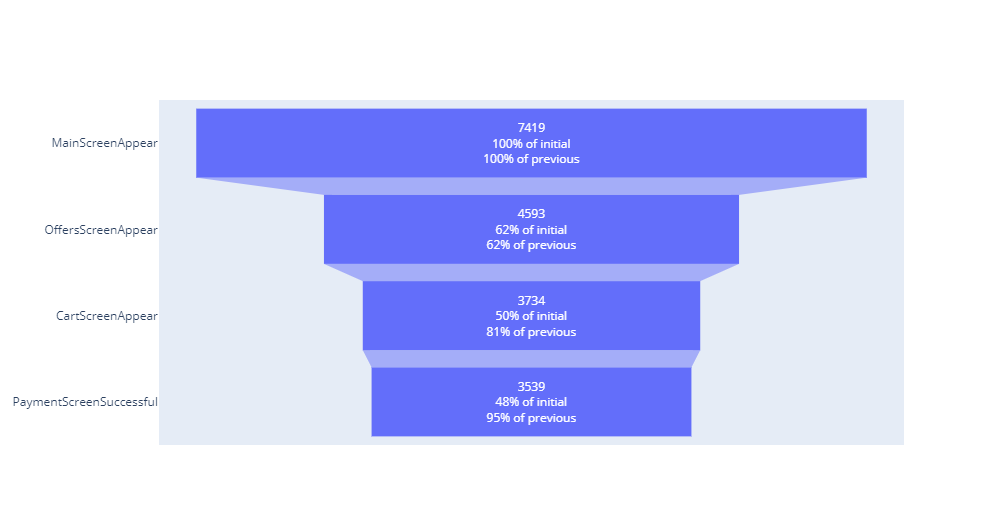

После первого экрана теряется почти 40% пользователей. Если на основном экране есть возможность сразу положить популярный товар в корзину, минуя подробное изучение на странице с предложениями, то все не так уж плохо. Но если нет, то нужно внимательно изучить удобство и функциональность основной страницы, поискать новые способы "заманить" пользователей на следующую страницу.   
Также необходимо учесть, что мы отбросили небольшую часть данных в процессе обработки, поэтому возможен вариант, что в нашей воронки есть пользователи, начавшие сразу со 2 или 3 шага. Правда, их процент невелик и вряд ли влияет очень существенно.

Расчет конверсии относительно первого экрана приложения:

In [34]:
user_event_fun['convfromone'] = round(user_event_fun['user_sum']*100/user_event_fun.loc[0,'user_sum'])
user_event_fun

,event,user_sum,conv,convfromone
0,MainScreenAppear,7419,100.0,100.0
1,OffersScreenAppear,4593,62.0,62.0
2,CartScreenAppear,3734,81.0,50.0
3,PaymentScreenSuccessful,3539,95.0,48.0


**Выводы:**   
Опредилили порядок событий по распределению процентов пользователей, перешедших на страницу:
- основной экран (MainScreenAppear) 98%;
- предложения (OffersScreenAppear) 61%;
- корзина (CartScreenAppear) 50%;
- успешная оплата (PaymentScreenSuccessful) 47%;
- просмотр руководства/справки (Tutorial) 11%.
Просмотр руководства не являются частью последовательности событий, оно может быть просмотрено в любой момент или вообще не открыто, что подтверждается 11% пользователей. Из воронки событий это событие можно исключить.   
Построили воронку событий с конверсией перехода пользователей на следующий шаг. Увидели, что больше всего пользователей теряется при переходе с основного экрана на экран предложений. Только 62% из них переходят к рассмотрению предложений. 81% из рассматривающих предложения наполняют свою корзину. И 95 % выкупают товары из корзины.   
После первого экрана теряется почти 40% пользователей. Если на основном экране есть возможность сразу положить популярный товар в корзину, минуя подробное изучение на странице с предложениями, то все не так уж плохо. Но если нет, то нужно внимательно изучить удобство и функциональность основной страницы, поискать новые способы "заманить" пользователей на следующую страницу.   
Также необходимо учесть, что мы отбросили небольшую часть данных в процессе обработки, поэтому возможен вариант, что в нашей воронке есть пользователи, начавшие сразу со 2 или 3 шага.   
Почти половина пользователей, зашедших на основную страницу приложения, успешно оплачивает покупку (48%).

## Изучение результатов эксперимента

Посчитаем количество пользователей в каждой экспериментальной группе:

In [35]:
user_group = funofev.pivot_table(index=['group'], values='user_id', aggfunc='nunique').reset_index()
user_group.rename(columns={'user_id': 'user_sum'}, inplace=True)
user_group

,group,user_sum
0,246,2483
1,247,2512
2,248,2535


Проверим, есть ли пересечения по пользователям в группах. Если какой-то из них попал в 2 или 3 группы одновременно, то сумма значений столбца 'user_sum' таблицы user_group будет больше количества уникальных пользователей первоначального массива funofev.

In [36]:
sum = user_group['user_sum'].sum()
print('Сумма пользователей по группам:', sum)

Сумма пользователей по группам: 7530


In [37]:
all=len(funofev['user_id'].unique())
print('Количество пользователей с уникальными id:', all)

Количество пользователей с уникальными id: 7530


Проанализируем, находят ли статистические критерии разницу между выборками 246 и 247. У нас есть размеры выборок в таблице user_group. Узнаем, сколько пользователей из каждой выборки доходит до успешной оплаты покупки.

In [38]:
part = funofev.query('event == "PaymentScreenSuccessful"').groupby('group').agg({'user_id': 'nunique'})
part

,user_id
group,
246,1200
247,1158
248,1181


Будем проводить проверку гипотез для пропорции или доли. Если некоторая доля генеральной совокупности обладает признаком, а другая её часть — нет, об этой доле можно судить по выборке из генеральной совокупности. Выборочные доли будут нормально распределены вокруг настоящей. Решим задачу сравнения пропорций двух генеральных совокупностей по выборкам из них. 
Разница между пропорциями, наблюдаемыми на выборках, будет нашей статистикой z_value. Так называется переменная, значения которой рассчитываются только по выборочным данным.

Подготовим данные для множественного эксперимента:
- распределение пользователей по всем группам сравнения, включая сборную контрольную группу;
- таблицу 'test', с распределением пользователей в воронке по событиям и их долями по всем группам для каждого события.

In [39]:
usersbygroup = funofev.groupby('group')['user_id'].nunique()
usersbygroup['ctrl'] = usersbygroup[246] + usersbygroup[247]
usersbygroup

group
246     2483
247     2512
248     2535
ctrl    4995
Name: user_id, dtype: int64

In [40]:
test = funofev.pivot_table(index='event', columns='group', values='user_id', aggfunc='nunique').reset_index()
test['ctrl'] = test[246] + test[247]
test['part246'] = (test[246]*100 / usersbygroup[246]).round()
test['part247'] = (test[247]*100 / usersbygroup[247]).round()
test['part248'] = (test[248]*100 / usersbygroup[248]).round()
test['part_ctrl'] = (test['ctrl']*100 / usersbygroup['ctrl']).round()
test

group,event,246,247,248,ctrl,part246,part247,part248,part_ctrl
0,CartScreenAppear,1266,1238,1230,2504,51.0,49.0,49.0,50.0
1,MainScreenAppear,2450,2476,2493,4926,99.0,99.0,98.0,99.0
2,OffersScreenAppear,1542,1520,1531,3062,62.0,61.0,60.0,61.0
3,PaymentScreenSuccessful,1200,1158,1181,2358,48.0,46.0,47.0,47.0


По таким подготовленным данным видно, что различия между долями групп от 0 до 2 %. И разбиение на группы проведено корректно.   
Самым популярным событием по этим данным является переход на основной экран MainScreenAppear для всех групп пользователей. Процент его совершения от 98 до 99. Будем считать, что миновали это событие 1-2% пользователей, чьи посещения мы откинули с данными за первую неделю(июль). Или перешедшие из поисковой строки, рассылки, рекламы прямо к рассмотрению или покупке.

Но необходимо проверить статистическую значимость этих различий. Для этого создадим функцию попарного сравнения данных разных групп:

In [41]:
def zval_test(gr1, gr2, alpha):
    for i in test.index:
        # пропорция успехов в первой группе:
        p1 = test[gr1][i] / usersbygroup[gr1]
        # пропорция успехов во второй группе:
        p2 = test[gr2][i] / usersbygroup[gr2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((test[gr1][i] + test[gr2][i]) / 
                      (usersbygroup[gr1] + usersbygroup[gr2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/usersbygroup[gr1] + 1/usersbygroup[gr2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(test['event'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

Сначала проведем А/А-тест - сравним результаты двух контрольных групп.
Н0: доли рассматриваемых групп (уникальных посетителей, побывавших на этапе воронки) не имеют существенных различий. Н1: различия между долями уникальных посетителей, побывавших на этапе воронки, есть.
Несколько сравнений, проводимых на одних и тех же данных — это множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Поэтому используем поправку по методу Бонферрони: делим уровень значимости ɑ на число событий 4 для 4 сравнений групп (246 и 247, 246 и 248, 247 и 248, 246+247 и 248), т.е. на 16.

In [42]:
zval_test(246, 247, 0.05/16)

CartScreenAppear p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Сравним экспериментальную группу с первой контрольной.  
Н0: доли рассматриваемых групп (уникальных посетителей, побывавших на этапе воронки) не имеют существенных различий. Н1: различия между долями уникальных посетителей, побывавших на этапе воронки, есть.

In [43]:
zval_test(246, 248, 0.05/16)

CartScreenAppear p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Проведем последовательно сравнения экспериментальной группы со второй контрольной и с объединенной контрольной:

In [44]:
zval_test(247, 248, 0.05/16)

CartScreenAppear p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [45]:
zval_test('ctrl', 248, 0.05/16)

CartScreenAppear p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Выводы:**   
Проанализировали, находят ли статистические критерии разницу между выборками 246 и 247.   
Выдвинули нулевую гипотезу Н0: между выборками нет статистически значимой разницы. Альтернативную гипотезу: между выборками есть значимая разница.
Провели проверку гипотез для пропорции или доли. Получили p-значение:  0.1145. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными. Значит А/А-эксперимент будет проведен корректно. Если две контрольные группы равны, мы можем быть уверены в точности проведенного тестирования.   
Далее подготовили данные для множественного эксперимента:
- распределение пользователей по всем группам сравнения, включая сборную контрольную группу;
- таблицу 'test', с распределением пользователей в воронке по событиям и их долями по всем группам для каждого события.   

И создали функцию для попарного сравнения наших групп. Сравнили каждую контрольную группу (246 и 247) с экспериментальной (248), а также сборную контрольную (246+247) с 248. Гипотезы. Н0: доли рассматриваемых групп не имеют существенных различий. Н1: различия между долями в группах есть.   
В результате всех проверок получили р-значение большее, чем критерий статистической значимости, и не отвергли нулевую гипотезу, т.к. нет оснований считать доли разными.  
Несколько сравнений, проводимых на одних и тех же данных — это множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Поэтому использовали поправку Бонферрони: делили уровень значимости ɑ на число событий (4) для 3 сравнений групп (246 и 248, 247 и 248, 246+247 и 248), т.е. на 12.   

Таким образом, нет повода считать, что изменение шрифтов как-либо повлияло на поведение пользователей.

## Общие выводы

Для того, чтобы разобраться, как ведут себя пользователи мобильного приложения по продаже продуктов питания были осуществлены следующие действия:
- изучение и обработка данных;
- изучение воронки продаж;
- исследование, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно;
- проверка результатов A/A/B-эксперимента по смене шрифта в приложениии.    
Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные (246 и 247) со старыми шрифтами и одну экспериментальную (248) — с новыми. Необходимо выяснить, какой шрифт лучше.

1)-2) **Изучение и обработка данных**(заменены названия столбцов со сменой регистра, проверены и откорректированы пропуски и типы данных, удалены полные дубликаты строк, добавлен столбец даты и времени, а также отдельный столбец дат). В результате изучения и проверки данных выянилось, что в массиве 43713 строк с 5 типами событий, 7551 уникальных идентификаторов пользователей. Имеются данные с 25 июля по 7 августа 2019 года, за 2 недели. При этом большая часть событий приходится на 2-ую неделю нашего интервала времени. Поэтому было принято решение оставить данные только за август, начиная с 01.08.2019. В результате потеряли менее 3000 событий и 17 пользователей. Также убедились в наличии пользователей всех трех экспериментальных групп в новом массиве.

3) **Изучение воронки продаж**   
Определен порядок событий по переходам пользователей:
  - основной экран (MainScreenAppear) 98%;
  - предложения (OffersScreenAppear) 61%;
  - корзина (CartScreenAppear) 50%;
  - успешная оплата (PaymentScreenSuccessful) 47%;
  - просмотр руководства/справки (Tutorial) 11%.   
  Просмотр руководства не является частью последовательности событий, оно может быть просмотрено в любой момент или вообще не открыто. Из воронки событий это событие исключено.   
  
Построена воронка событий с конверсией перехода пользователей на следующий шаг. Сделан вывод, что больше всего пользователей теряется при переходе с основного экрана на экран предложений. Только 62% из них переходят к рассмотрению предложений. 81% из рассматривающих предложения наполняют свою корзину. И 95 % выкупают товары из корзины.
После первого экрана теряется почти 40% пользователей. Если на основном экране есть возможность сразу положить популярный товар в корзину или осуществить быструю покупку, минуя подробное изучение на странице с предложениями, то все не так уж плохо. Но если нет, то нужно внимательно изучить удобство и функциональность основной страницы, поискать новые способы "заманить" пользователей на следующую страницу.
Также необходимо учесть, что мы отбросили небольшую часть данных в процессе обработки, поэтому возможен вариант, что в нашей воронке есть пользователи, начавшие сразу со 2 или 3 шага.
Судя по конверсии от первого шага до оплаты, почти половина пользователей, зашедших на основную страницу приложения, успешно оплачивает покупку (48%).

4) **Проверка результатов A/A/B-эксперимента по смене шрифта в приложениии**   
  
 Подготовили данные с количеством пользователей каждой группы на каждом шаге воронки событий. 
 Сравнили выборки для проведения А/А-теста. Выдвинули нулевую гипотезу Н0: между выборками нет статистически значимой разницы. Альтернативную гипотезу: между выборками есть значимая разница. Провели проверку гипотез для пропорции или доли. Получили p-значение: 0.1145. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными. Значит А/А-эксперимент будет проведен корректно. Если две контрольные группы равны, мы можем быть уверены в точности проведенного тестирования.    
 И с помощью созданной функции сравнили каждую контрольную группу (246 и 247) с экспериментальной (248), а также сборную контрольную (246+247) с ней же.   
 Гипотезы. Н0: доли рассматриваемых групп не имеют существенных различий. Н1: различия между долями в группах есть.
В результате всех проверок получили р-значение большее, чем критерий статистической значимости, и не отвергли нулевую гипотезу, т.к. нет оснований считать доли разными.
Несколько сравнений, проводимых на одних и тех же данных — это множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Поэтому использовали поправку Бонферрони: делили уровень значимости ɑ на число событий (4) для 4 сравнений групп (246 и 247, 246 и 248, 247 и 248, 246+247 и 248), т.е. на 16.

**Таким образом, нет повода считать, что изменение шрифтов как-либо повлияло на поведение пользователей.**